
Statistiques de base:
Nombre total de produits             84916.000000
Nombre de catégories uniques            27.000000
% de descriptions manquantes            35.093504
Longueur moyenne des désignations       70.163303
Nombre d'images uniques              84916.000000
dtype: float64

Analyse de la distribution des catégories:
Test Chi2 d'uniformité: p-value = 0.0


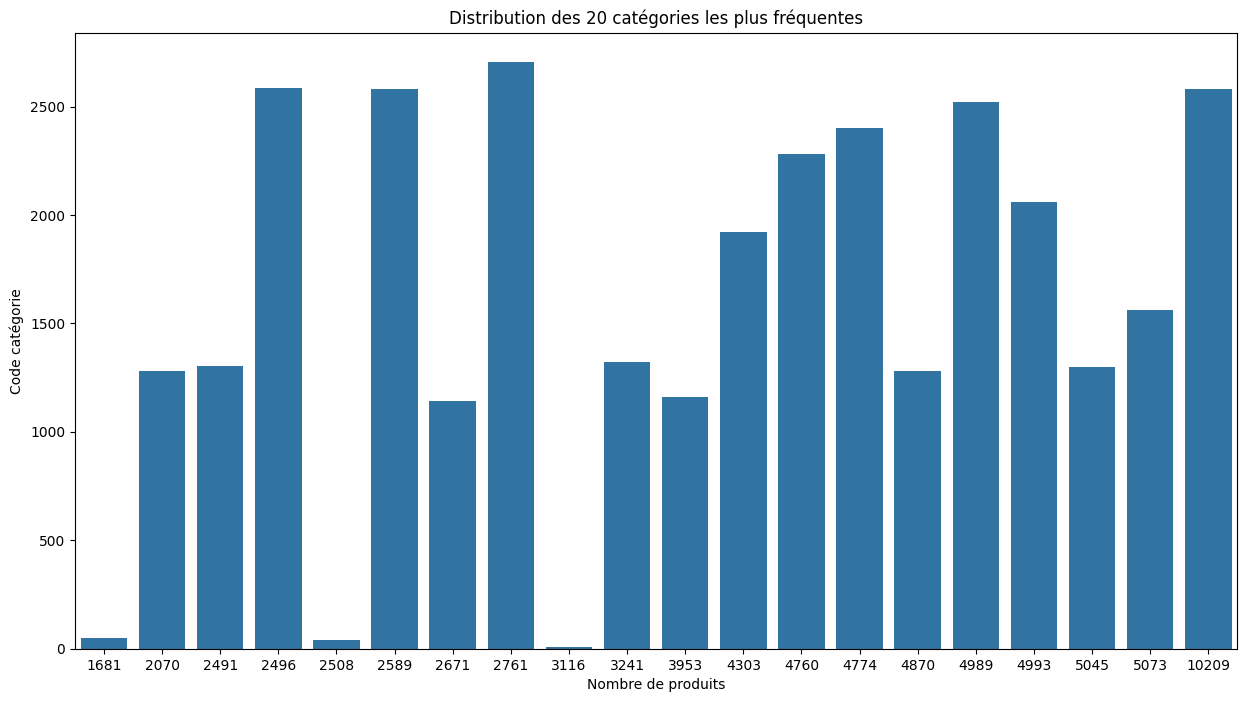


Analyse des longueurs de texte:
Test KS entre désignations et descriptions: p-value = 0.0


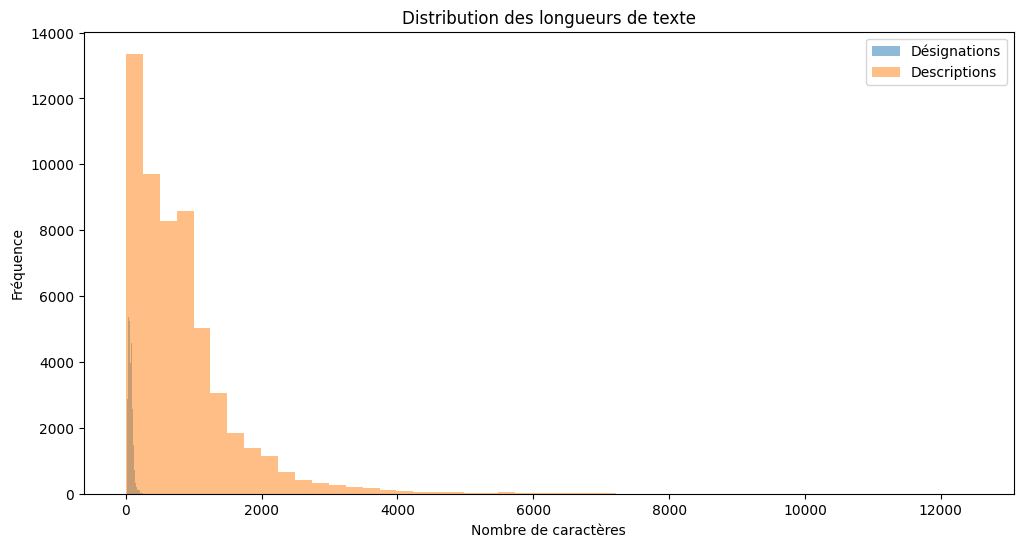


Analyse des mots fréquents:


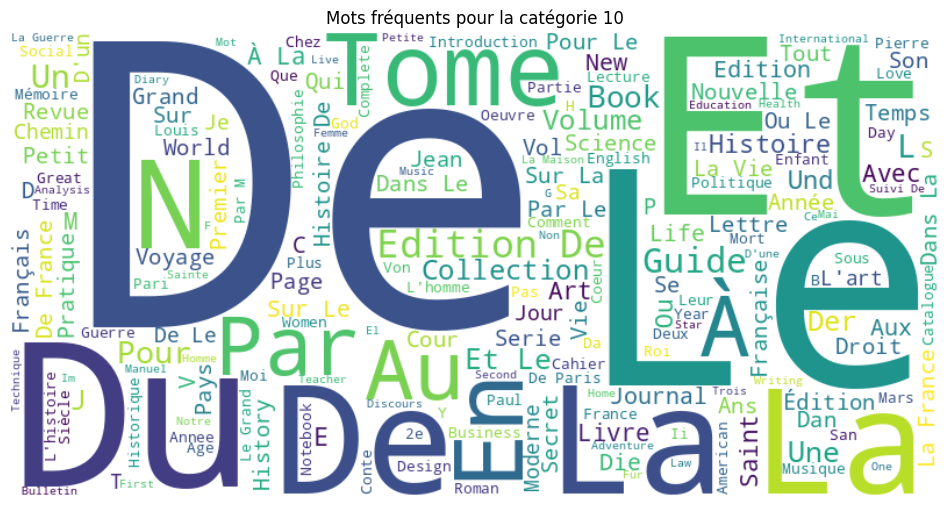


Analyse des propriétés des images:


100%|██████████| 1000/1000 [00:04<00:00, 237.19it/s]


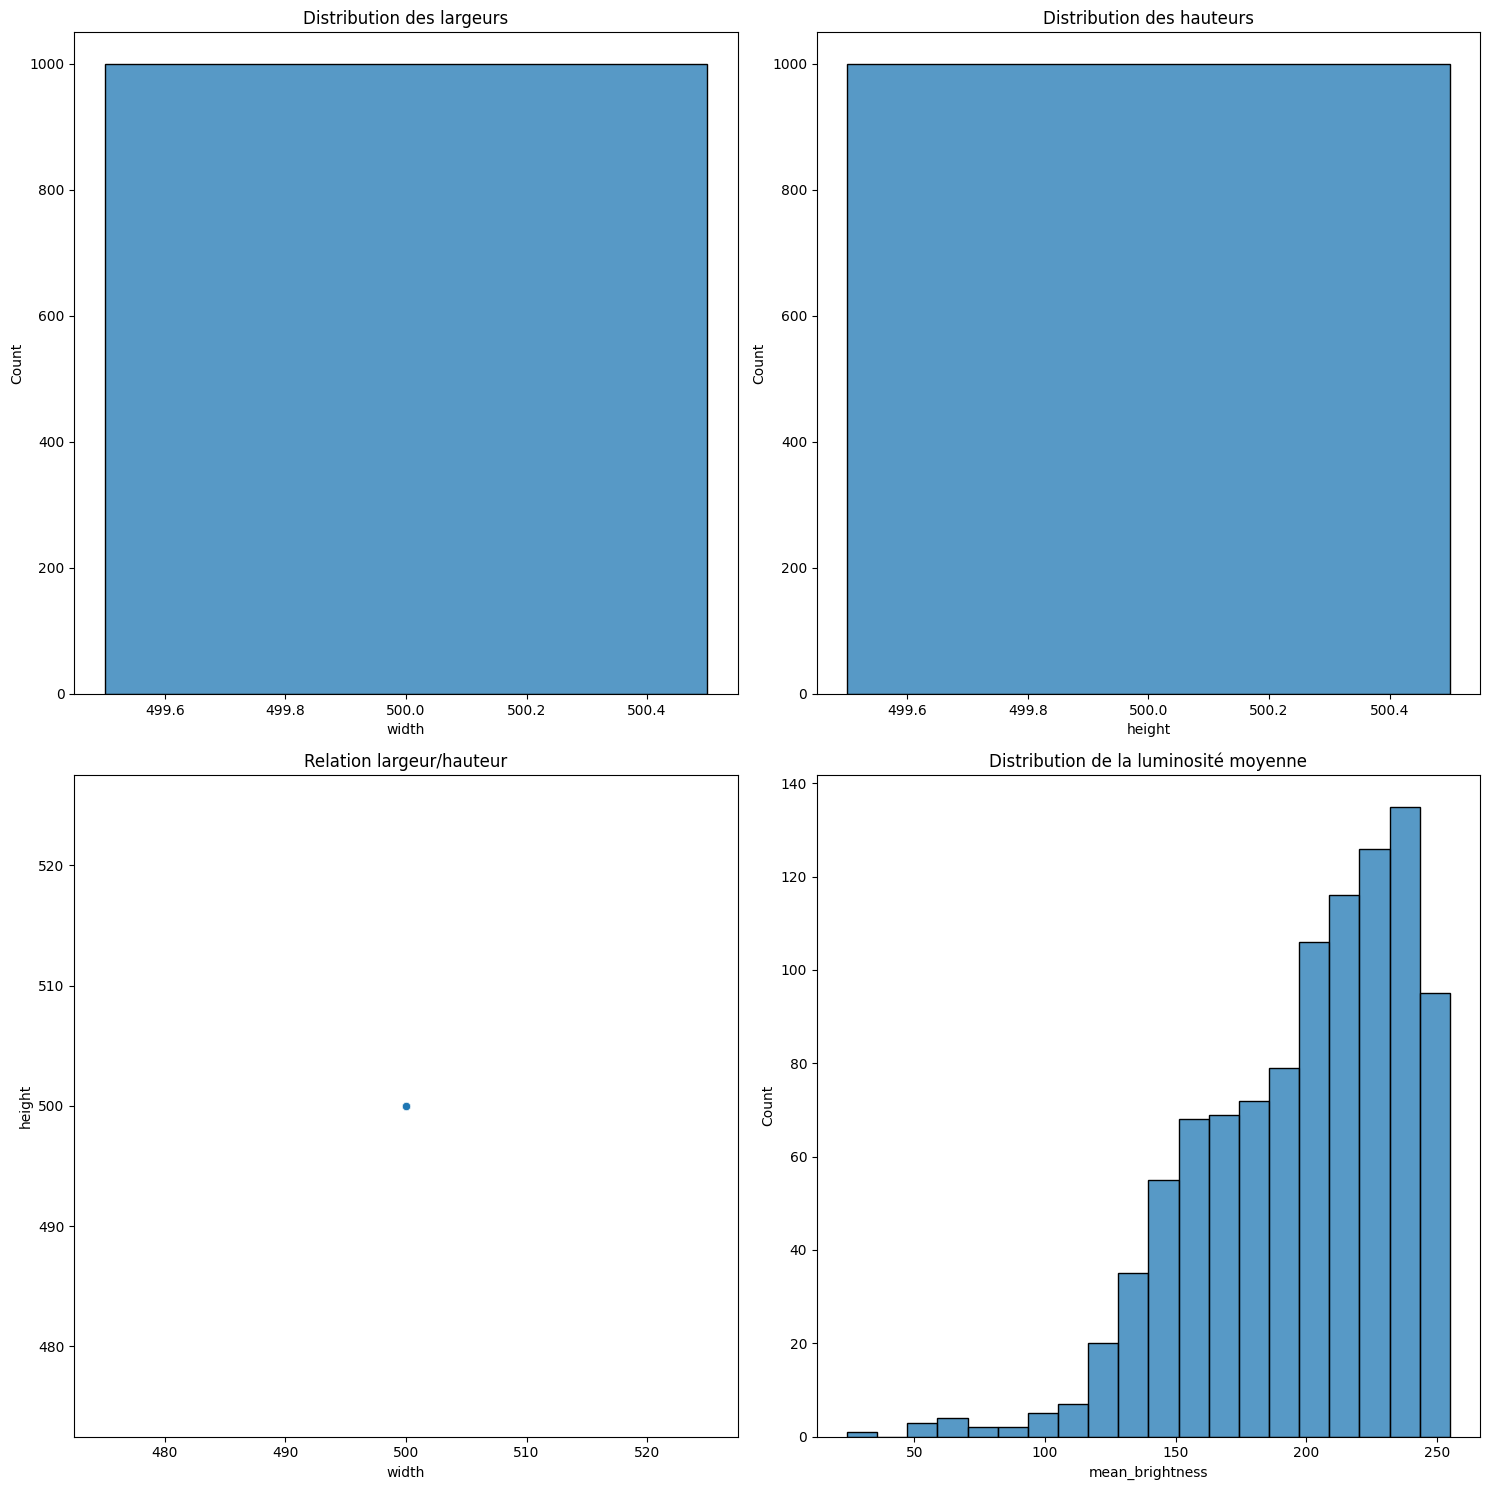


Analyse de la relation entre catégories et images:


100%|██████████| 84916/84916 [05:49<00:00, 243.00it/s]


NameError: name 'f_oneway' is not defined

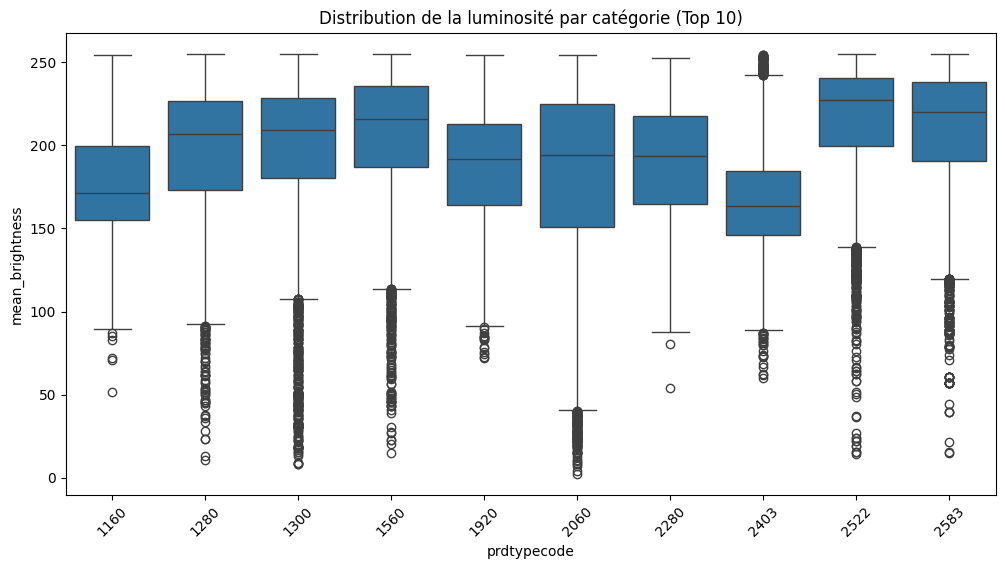

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import Counter
from wordcloud import WordCloud # https://datascientest.com/wordcloud-python
from tqdm import tqdm

class RakutenExplorer:
    def __init__(self, X_train_path, y_train_path, image_folder):
        """Initialisation avec les chemins des fichiers"""
        self.X_train = pd.read_csv(X_train_path)
        self.y_train = pd.read_csv(y_train_path)
        self.image_folder = image_folder
        self.merged_data = pd.merge(self.X_train, self.y_train, left_index=True, right_index=True)
        
        # Vérification du dossier images
        if not os.path.exists(self.image_folder):
            raise ValueError(f"Le dossier d'images {self.image_folder} n'existe pas!")
        
    def basic_statistics(self):
        """Statistiques de base sur le dataset"""
        stats = {
            "Nombre total de produits": len(self.X_train),
            "Nombre de catégories uniques": len(self.y_train['prdtypecode'].unique()),
            "% de descriptions manquantes": (self.X_train['description'].isna().sum() / len(self.X_train)) * 100,
            "Longueur moyenne des désignations": self.X_train['designation'].str.len().mean(),
            "Nombre d'images uniques": len(set(self.X_train['imageid']))
        }
        return pd.Series(stats)

    def plot_category_distribution(self, figsize=(15, 8)):
        """Visualisation 1: Distribution des catégories"""
        plt.figure(figsize=figsize)
        category_counts = self.y_train['prdtypecode'].value_counts()
        
        sns.barplot(x=category_counts.values[:20], y=category_counts.index[:20])
        plt.title('Distribution des 20 catégories les plus fréquentes')
        plt.xlabel('Nombre de produits')
        plt.ylabel('Code catégorie')
        
        # Test statistique : Chi-square test for uniformity
        from scipy.stats import chisquare
        chi2_stat, p_value = chisquare(category_counts)
        print(f"Test Chi2 d'uniformité: p-value = {p_value}")
        
        return category_counts

    def analyze_text_length(self, figsize=(12, 6)):
        """Visualisation 2: Distribution des longueurs de texte"""
        plt.figure(figsize=figsize)
        
        designation_lengths = self.X_train['designation'].str.len()
        description_lengths = self.X_train['description'].dropna().str.len()
        
        plt.hist(designation_lengths, bins=50, alpha=0.5, label='Désignations')
        plt.hist(description_lengths, bins=50, alpha=0.5, label='Descriptions')
        plt.title('Distribution des longueurs de texte')
        plt.xlabel('Nombre de caractères')
        plt.ylabel('Fréquence')
        plt.legend()
        
        # Test statistique : Kolmogorov-Smirnov test
        from scipy.stats import ks_2samp
        ks_stat, p_value = ks_2samp(designation_lengths, description_lengths)
        print(f"Test KS entre désignations et descriptions: p-value = {p_value}")
        
        return designation_lengths.describe(), description_lengths.describe()

    def create_wordcloud_by_category(self, category_code, figsize=(12, 8)):
        """Visualisation 3: Nuage de mots par catégorie"""
        category_texts = self.merged_data[self.merged_data['prdtypecode'] == category_code]['designation']
        text = ' '.join(category_texts)
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        plt.figure(figsize=figsize)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Mots fréquents pour la catégorie {category_code}')
        
        # Analyse statistique des mots
        words = text.split()
        word_freq = Counter(words)
        return pd.Series(word_freq).sort_values(ascending=False).head(10)

    def analyze_image_properties(self, sample_size=1000):
        """Visualisation 4: Analyse des propriétés des images"""
        image_properties = []
        
        # Échantillonnage aléatoire pour l'analyse
        sampled_rows = self.X_train.sample(n=min(sample_size, len(self.X_train)))
        
        for _, row in tqdm(sampled_rows.iterrows(), total=len(sampled_rows)):
            image_path = os.path.join(
                self.image_folder,
                f"image_{row['imageid']}_product_{row['productid']}.jpg"
            )
            try:
                with Image.open(image_path) as img:
                    properties = {
                        'height': img.size[1],
                        'width': img.size[0],
                        'aspect_ratio': img.size[0] / img.size[1],
                        'mean_brightness': np.mean(np.array(img.convert('L')))
                    }
                    image_properties.append(properties)
            except Exception as e:
                print(f"Erreur avec l'image {image_path}: {e}")
                continue
                
        df_properties = pd.DataFrame(image_properties)
        
        # Création des visualisations
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        
        sns.histplot(data=df_properties, x='width', ax=axes[0,0])
        axes[0,0].set_title('Distribution des largeurs')
        
        sns.histplot(data=df_properties, x='height', ax=axes[0,1])
        axes[0,1].set_title('Distribution des hauteurs')
        
        sns.scatterplot(data=df_properties, x='width', y='height', ax=axes[1,0])
        axes[1,0].set_title('Relation largeur/hauteur')
        
        sns.histplot(data=df_properties, x='mean_brightness', ax=axes[1,1])
        axes[1,1].set_title('Distribution de la luminosité moyenne')
        
        plt.tight_layout()
        
        return df_properties.describe()

    def analyze_category_image_relationship(self, figsize=(12, 6)):
        """Visualisation 5: Relation entre catégories et propriétés des images"""
        image_properties = []
        
        for _, row in tqdm(self.merged_data.iterrows(), total=len(self.merged_data)):
            image_path = os.path.join(
                self.image_folder,
                f"image_{row['imageid']}_product_{row['productid']}.jpg"
            )
            try:
                with Image.open(image_path) as img:
                    properties = {
                        'prdtypecode': row['prdtypecode'],  # Utiliser le même nom que dans les données
                        'mean_brightness': np.mean(np.array(img.convert('L'))),
                        'aspect_ratio': img.size[0] / img.size[1]
                    }
                    image_properties.append(properties)
            except Exception as e:
                continue
                    
        df_properties = pd.DataFrame(image_properties)
        
        # Limiter à top 10 catégories pour une meilleure lisibilité
        top_categories = self.merged_data['prdtypecode'].value_counts().nlargest(10).index
        df_plot = df_properties[df_properties['prdtypecode'].isin(top_categories)]
        
        plt.figure(figsize=figsize)
        sns.boxplot(x='prdtypecode', y='mean_brightness', data=df_plot)
        plt.xticks(rotation=45)
        plt.title('Distribution de la luminosité par catégorie (Top 10)')
        
        # Test statistique : ANOVA
        categories = df_properties['prdtypecode'].unique()
        brightness_by_category = [
            df_properties[df_properties['prdtypecode'] == cat]['mean_brightness'] 
            for cat in categories
        ]
        f_stat, p_value = f_oneway(*brightness_by_category)
        print(f"ANOVA test pour la luminosité entre catégories: p-value = {p_value}")
        
        return df_properties.groupby('prdtypecode')['mean_brightness'].describe()

# Exemple d'utilisation
if __name__ == "__main__":
    explorer = RakutenExplorer(
        X_train_path='Raw_data/X_train_update.csv',
        y_train_path='Raw_data/Y_train_CVw08PX.csv',
        image_folder='Raw_data/images/image_train'
    )
    
    # Statistiques de base
    print("\nStatistiques de base:")
    print(explorer.basic_statistics())
    
    # Distribution des catégories
    print("\nAnalyse de la distribution des catégories:")
    explorer.plot_category_distribution()
    plt.show()
    
    # Analyse des textes
    print("\nAnalyse des longueurs de texte:")
    explorer.analyze_text_length()
    plt.show()
    
    # Nuage de mots pour une catégorie
    print("\nAnalyse des mots fréquents:")
    explorer.create_wordcloud_by_category(category_code=10)
    plt.show()
    
    # Analyse des images
    print("\nAnalyse des propriétés des images:")
    explorer.analyze_image_properties()
    plt.show()
    
    # Relation catégories-images
    print("\nAnalyse de la relation entre catégories et images:")
    explorer.analyze_category_image_relationship()
    plt.show()